In [1]:
import servo
import analyse
import plot

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
def timestamps_to_displacement(timestamped_data, velocity):

    data = (timestamped_data
            .pipe(servo.reindex_timestamps_with_times)
            .pipe(servo.calculate_displacement, velocity)
           )
    displacement_data = data.set_index("Displacement (m)")

    
    return displacement_data
    

def plot_knife_edge_method(ax, dataset):
    xs = dataset.index.values*1E3 # in mm
    ys = dataset["Power (W)"].values*1E6 # in uW
    
    coeffs, coeff_errs = analyse.fit_erf(xs, ys)
    fit_ys = analyse.erf(xs, *coeffs)

    gauss_ys = analyse.G(xs, 2*coeffs[0], coeffs[1], coeffs[2]/np.sqrt(2))

    lower_bound, upper_bound = analyse.get_e_squared_range(xs, gauss_ys)

    ax.set_xlabel("Displacement [mm]")
    
    ax.plot(xs, ys, marker='.', linestyle='', color="tab:blue", label="meas")
    ax.plot(xs, fit_ys,linestyle='--', linewidth=3, color="tab:red", label="erf fit")
    ax.plot(xs, gauss_ys, linestyle='--', linewidth=3, color="tab:purple", label="gauss fit")
    
    plot.draw_dimension_lines(ax, upper_bound, lower_bound)
    ax.vlines(lower_bound, 0, max(ys), linestyle=':', linewidth=2, color="black")
    ax.vlines(upper_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")

    return upper_bound - lower_bound

def plot_result(file, velocity):
    timestamped_knife_measurements = servo.get_data(file)

    displacement_data = timestamps_to_displacement(timestamped_knife_measurements, velocity)
    
    fig, axes = plt.subplots()
    axes.set_ylabel("Power (uW)")
    diameter = plot_knife_edge_method(axes, displacement_data)

    handles, labels = axes.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.1, 0.85, 0.8, 0.1))
    #plt.tight_layout()
    return diameter

def plot_results_for_each(knife_measurement, velocity):
    timestamped_knife_measurements = map(servo.get_data, knife_measurement)
    displacement_data = map(
        lambda m: timestamps_to_displacement(m, velocity),
        timestamped_knife_measurements
    )
    fig, axes = plt.subplots(1,len(knife_measurement),figsize=(15,5), dpi=250, sharey=True)
    axes = [axes]
    axes[0].set_ylabel("Power (uW)")
    diameters = np.array([
        plot_knife_edge_method(ax, data) for ax, data in zip(axes, [*displacement_data])
    ])
    mean_diam = diameters.mean()
    mean_diam_err = diameters.std()/np.sqrt(len(diameters))
    fig.suptitle(f"Mean Beam Diameter: {round(mean_diam, 3)} +/- {round(mean_diam_err, 3)}")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.1, 0.85, 0.8, 0.1))
    plt.tight_layout()
    return mean_diam, mean_diam_err

23.68515


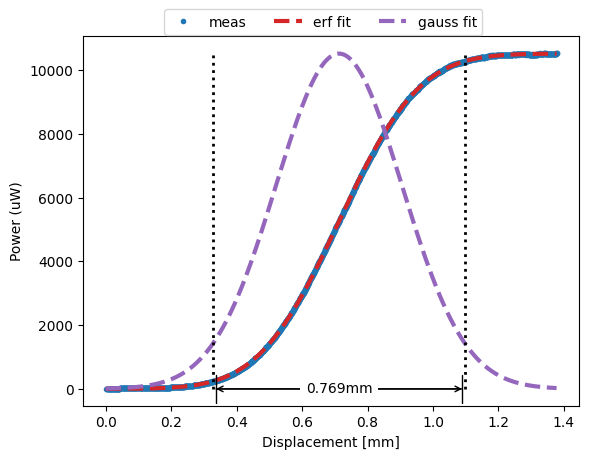

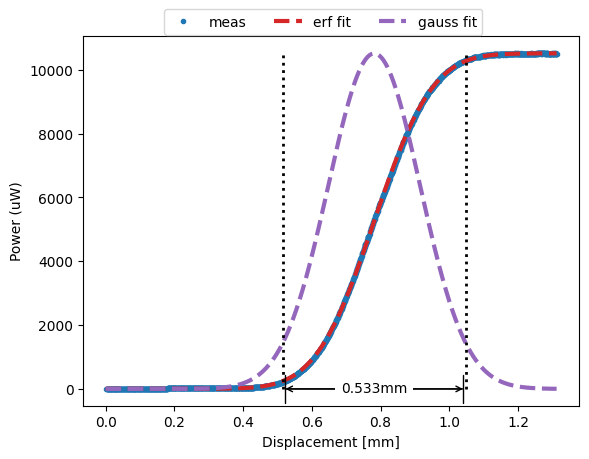

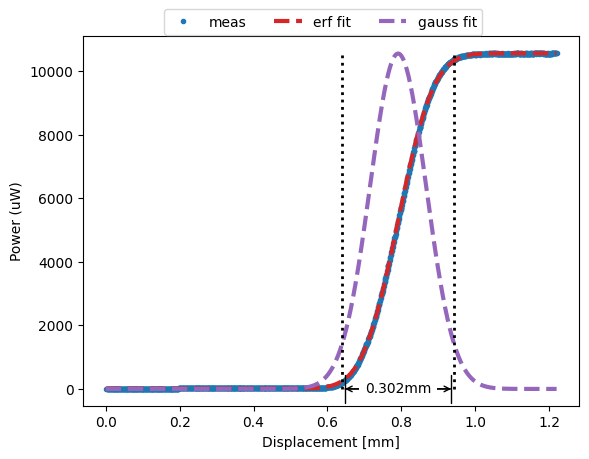

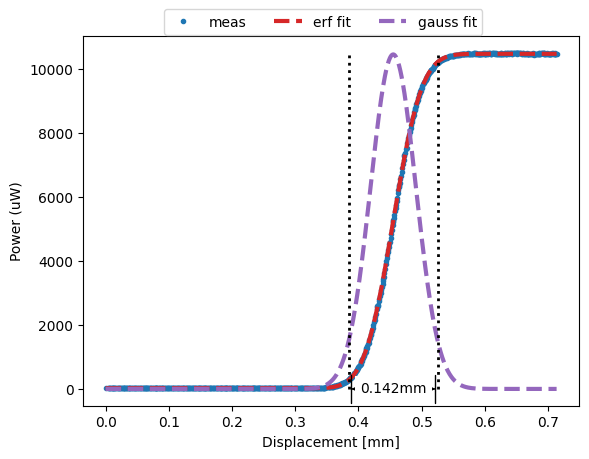

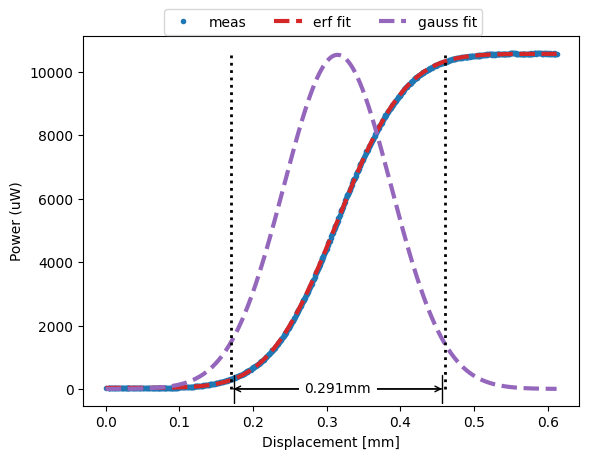

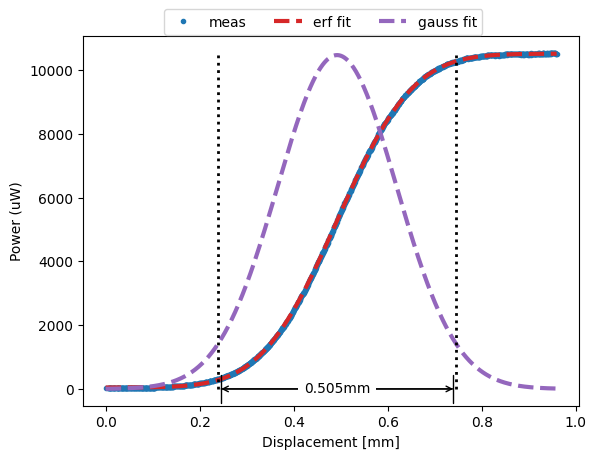

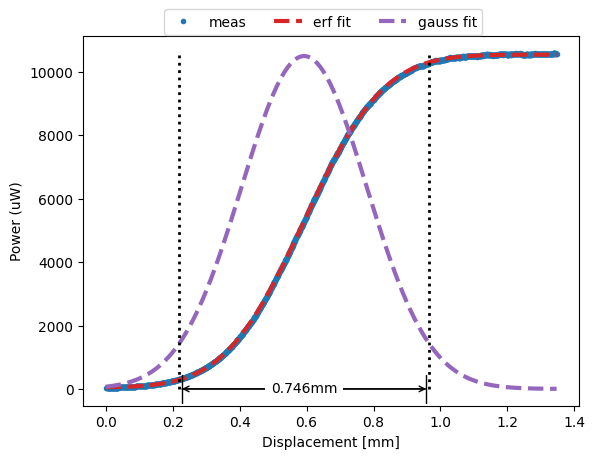

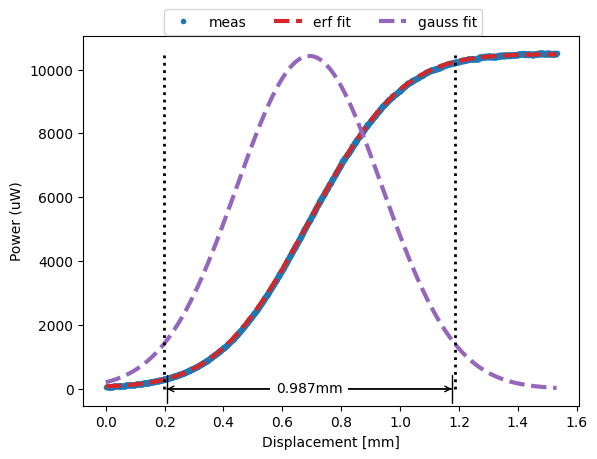

In [43]:
slow_v_d = pd.read_csv("Data/speed_1_data.txt", delimiter=",", header=1, usecols=[0,1])
velocity = analyse.get_average_velocity(slow_v_d)

files = [ f"./Data/foc/{p}.csv" for p in range(7,15,1) ]
diams = np.array(list(map(lambda f, v: plot_result(f, v), files, np.repeat(velocity, len(files)))))

    
    
#results_1 = list(map(lambda position,v: plot_results_for_each(position, v), files, [velocity, velocity, velocity]))


[0.13498 0.15998 0.18498 0.20998 0.23498 0.25998 0.28498 0.30998]
[0.76885454 0.53295085 0.3021112  0.14175876 0.29055089 0.50534592
 0.74615166 0.9870256 ]
[2.07537793e-06 1.24339808e-03]


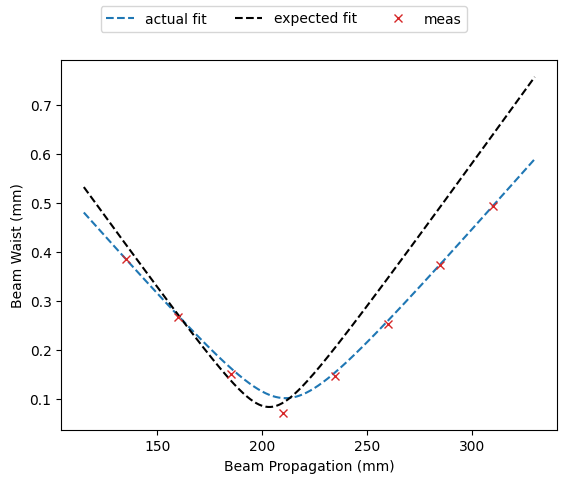

In [44]:
p0 = 134.76 - 0.68 + 0.9
ps = np.array([ p0 + (p * 25) for p in range(0, 8, 1) ]) * 1E-3
print(ps)
print(diams)
from scipy.optimize import curve_fit

def plot_beam_propagation(ax, results, ps):
    ws = results * 1E-3 / 2 #np.array([ res[0] for res in results ]) * 1E-3 / 2
    #ws_errs = np.array([ res[1] for res in results ]) * 1E-3 / 2

    coeffs, pcov = curve_fit(analyse.beam_radius, ps, ws, p0=(80E-6, 200E-3))
    print(np.sqrt(np.diag(pcov)))
    fit_ws = analyse.beam_radius(ps, *coeffs)

    fake_ps = np.linspace(min(ps)-20E-3, max(ps) + 20E-3, 1000)
    expected_ws = np.array(list(map(lambda p: analyse.beam_radius(p, 83E-6, 203.4E-3), fake_ps)))
    fit_ws = np.array(list(map(lambda p: analyse.beam_radius(p, *coeffs), fake_ps)))
    

    ax.plot(fake_ps*1E3, fit_ws*1E3, linestyle='--', c="tab:blue",label="actual fit")
    ax.plot(fake_ps*1E3, expected_ws*1E3, linestyle='--', c='k', label="expected fit")
    #ax.errorbar(ps*1E3, ws*1E3, yerr=ws_errs*1E3, linestyle='', marker='x', color="tab:red", label="meas")
    ax.plot(ps*1E3, ws*1E3, linestyle='', marker='x', color="tab:red", label="meas")
    ax.set_xlabel("Beam Propagation (mm)")
    ax.set_ylabel("Beam Waist (mm)")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3)

fig, ax = plt.subplots()
plot_beam_propagation(ax, diams, ps)

[5.14614645e-07 4.93963945e-04]
The beam waist is:  54.45442523751597 mm
Rayleigh Length is: 6.0101392094492425 mm
The expected Rayleigh length is 3.5211267605633805 mm
Percentage Difference =  26.114185216495077


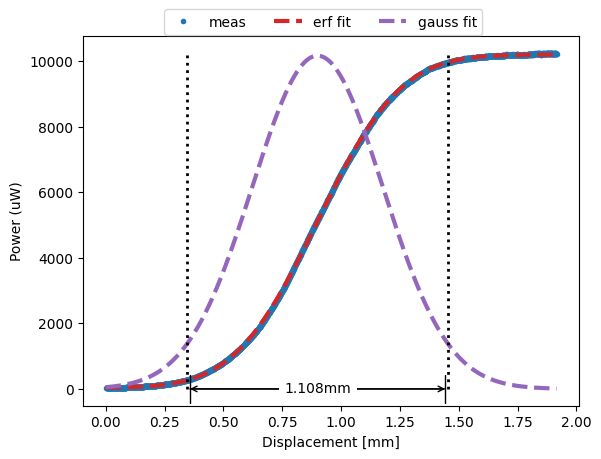

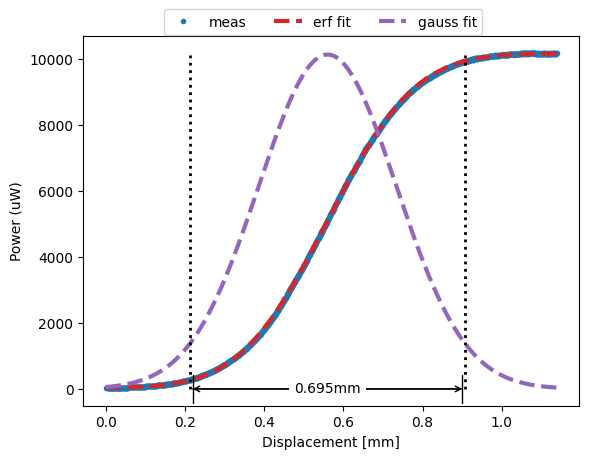

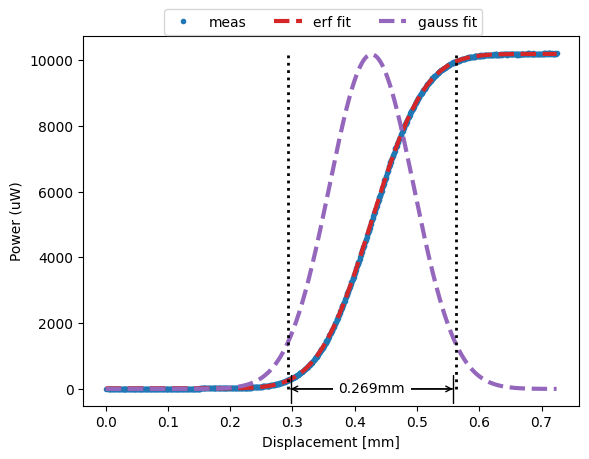

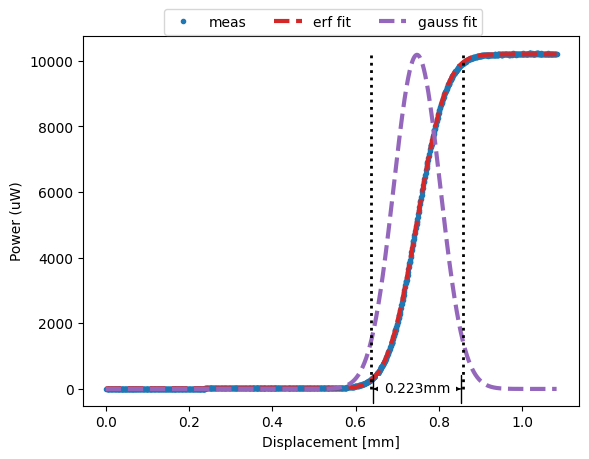

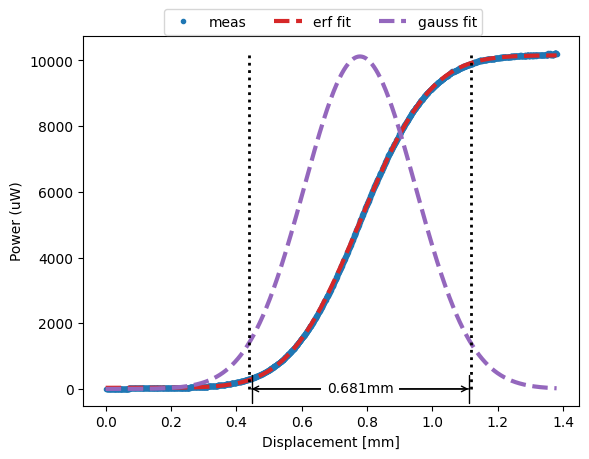

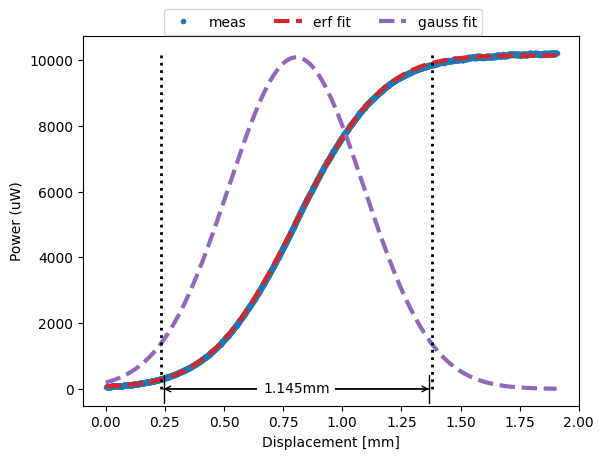

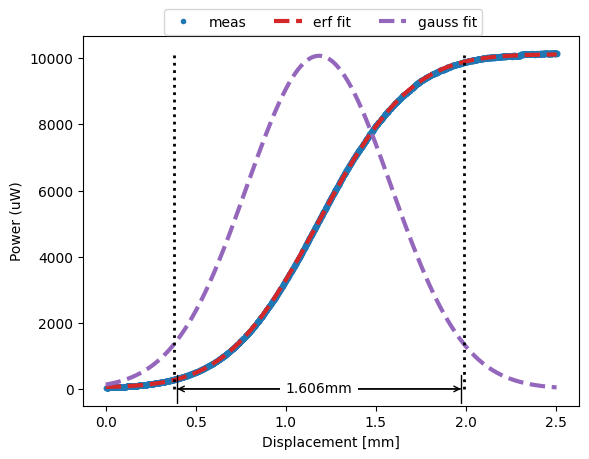

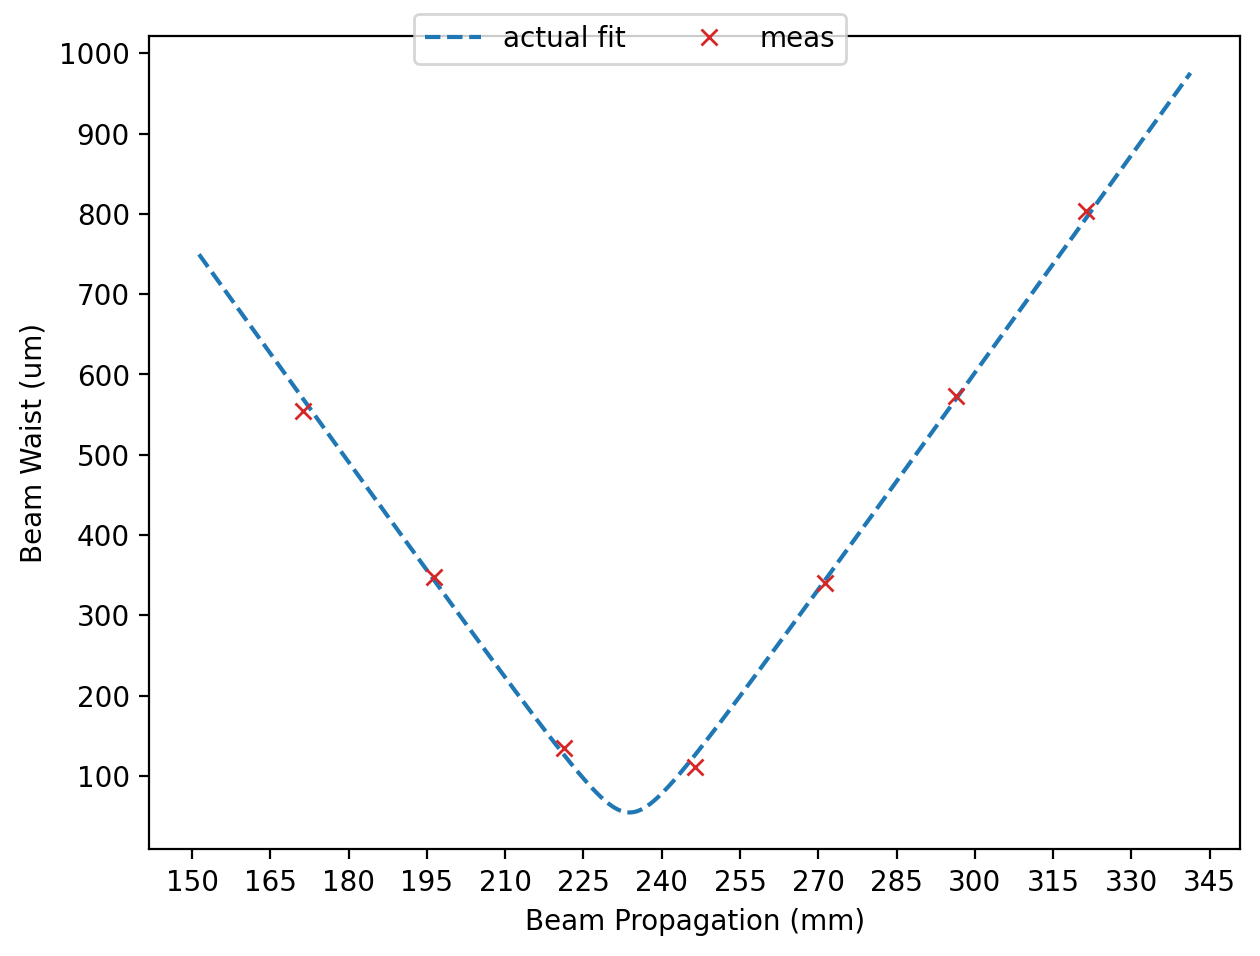

In [72]:
p0 = 172 - 0.68
ps = np.array([ p0 + (p * 25) for p in range(0, 7, 1) ]) * 1E-3
files = [ f"./Data/2f/{p}.csv" for p in range(8,15,1) ]
diams = np.array(list(map(lambda f, v: plot_result(f, v), files, np.repeat(velocity, len(files)))))
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

def plot_beam_propagation(ax, results, ps):
    ws = results * 1E-3 / 2 #np.array([ res[0] for res in results ]) * 1E-3 / 2
    #ws_errs = np.array([ res[1] for res in results ]) * 1E-3 / 2

    coeffs, pcov = curve_fit(analyse.beam_radius, ps, ws, p0=(45E-6, 200E-3))
    print(np.sqrt(np.diag(pcov)))
    fit_ws = analyse.beam_radius(ps, *coeffs)

    fake_ps = np.linspace(min(ps)-20E-3, max(ps) + 20E-3, 1000)
    expected_ws = np.array(list(map(lambda p: analyse.beam_radius(p, 42E-6, 222.4E-3), fake_ps)))
    fit_ws = np.array(list(map(lambda p: analyse.beam_radius(p, *coeffs), fake_ps)))
    w0 = min(fit_ws)
    zR = (np.pi * (w0**2))/1550E-9
    target_zR = (20*1E-3)/(2*2.84)
    print("The beam waist is: ", w0*1E6,"mm")
    print("Rayleigh Length is:", zR*1E3, "mm")
    print("The expected Rayleigh length is", target_zR*1E3 ,"mm")
    print("Percentage Difference = ", abs(target_zR - zR) / (zR + target_zR) * 100)

    ax.plot(fake_ps*1E3, fit_ws*1E6, linestyle='--', c="tab:blue",label="actual fit")
    #ax.plot(fake_ps*1E3, expected_ws*1E3, linestyle='--', c='k', label="expected fit")
    #ax.errorbar(ps*1E3, ws*1E3, yerr=ws_errs*1E3, linestyle='', marker='x', color="tab:red", label="meas")
    ax.plot(ps*1E3, ws*1E6, linestyle='', marker='x', color="tab:red", label="meas")
    ax.set_xlabel("Beam Propagation (mm)")
    ax.set_ylabel("Beam Waist (um)")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3)
    plt.tight_layout()

fig, ax = plt.subplots(dpi=200)
plot_beam_propagation(ax, diams, ps)